In [1]:
!pip install ultralytics==8.3.124 -q

# Imports

In [2]:
import os
import glob
import yaml 
import random
import shutil
import torch 

import cv2
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO

# Constants

In [3]:
# --- Configuration ---
BASE_DATA_DIR = '/kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset'
ORIGINAL_DATA_DIR = os.path.join(BASE_DATA_DIR, 'Original_Data')
AUGMENTED_DATA_DIR = os.path.join(BASE_DATA_DIR, 'Augmented_Data')

# Define paths for augmented data splits
TRAIN_IMG_DIR = os.path.join(AUGMENTED_DATA_DIR, 'train', 'images')
TRAIN_LBL_DIR = os.path.join(AUGMENTED_DATA_DIR, 'train', 'labels')
VALID_IMG_DIR = os.path.join(AUGMENTED_DATA_DIR, 'valid', 'images')
VALID_LBL_DIR = os.path.join(AUGMENTED_DATA_DIR, 'valid', 'labels')
TEST_IMG_DIR = os.path.join(AUGMENTED_DATA_DIR, 'test', 'images')
TEST_LBL_DIR = os.path.join(AUGMENTED_DATA_DIR, 'test', 'labels')

# Class names corresponding to IDs 0-5
class_names = ['Caries', 'Infection', 'Impacted Teeth', 'Fractured Teeth', 'Broken Crown', 'Healthy']
num_classes = len(class_names)

# Using relative paths makes the yaml file more portable
INPUT_DATA_DIR = '/kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data'
TRAIN_IMG_DIR_REL = os.path.join(INPUT_DATA_DIR, 'train', 'images')
VALID_IMG_DIR_REL = os.path.join(INPUT_DATA_DIR, 'valid', 'images')
TEST_IMG_DIR_REL = os.path.join(INPUT_DATA_DIR, 'test', 'images')

# Output directory for the yaml file (in the working directory)
YAML_DIR = '/kaggle/working/'
yaml_file_path = os.path.join(YAML_DIR, 'dental_opg_dataset.yaml')

# Step1: Verify Folder Structure

In [4]:
def check_and_count_files(dir_path, extensions=['.jpg', '.txt', '.json']):
    """Checks if a directory exists and counts files with given extensions."""
    if not os.path.isdir(dir_path):
        print(f"Directory NOT FOUND: {dir_path}")
        return None
    
    counts = {ext: 0 for ext in extensions}
    all_files = glob.glob(os.path.join(dir_path, '*'))
    
    for f in all_files:
        for ext in extensions:
            if f.lower().endswith(ext):
                counts[ext] += 1
                break # Count each file only once based on the first matching extension
                
    count_str = ", ".join([f"{count} {ext}" for ext, count in counts.items() if count > 0])
    print(f"Found: {dir_path} - Contains: {count_str if count_str else '0 files specified'}")
    return counts

# Check Original Data
print("\n[Original Data]")
# Note: Original data description mentions .json labels, but the folder structure implies .txt. Let's check both.
# Correction based on user prompt: Original_Data also has .txt labels.
original_img_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.jpg'))
original_lbl_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.txt'))
print(f"Found: {ORIGINAL_DATA_DIR}")
print(f"  - Images (.jpg): {len(original_img_files)}")
print(f"  - Labels (.txt): {len(original_lbl_files)}")
# If JSON exists, check them too:
original_json_files = glob.glob(os.path.join(ORIGINAL_DATA_DIR, '*.json'))
if original_json_files:
    print(f"  - Labels (.json): {len(original_json_files)}")


# Check Augmented Data
print("\n[Augmented Data]")
train_img_count = len(glob.glob(os.path.join(TRAIN_IMG_DIR, '*.jpg')))
train_lbl_count = len(glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt')))
valid_img_count = len(glob.glob(os.path.join(VALID_IMG_DIR, '*.jpg')))
valid_lbl_count = len(glob.glob(os.path.join(VALID_LBL_DIR, '*.txt')))
test_img_count = len(glob.glob(os.path.join(TEST_IMG_DIR, '*.jpg')))
test_lbl_count = len(glob.glob(os.path.join(TEST_LBL_DIR, '*.txt')))

print(f"Train: Images={train_img_count}, Labels={train_lbl_count}")
print(f"Valid: Images={valid_img_count}, Labels={valid_lbl_count}")
print(f"Test:  Images={test_img_count}, Labels={test_lbl_count}")

# Basic consistency check
if train_img_count != train_lbl_count or valid_img_count != valid_lbl_count or test_img_count != test_lbl_count:
    print("\n*** WARNING: Mismatch between image and label counts in augmented data splits! ***")
else:
    print("\nImage and label counts match in augmented data splits.")


[Original Data]
Found: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Original_Data
  - Images (.jpg): 232
  - Labels (.txt): 232

[Augmented Data]
Train: Images=567, Labels=558
Valid: Images=23, Labels=23
Test:  Images=23, Labels=23

*** WARNING: Mismatch between image and label counts in augmented data splits! ***


## Step 2: Examine Label Format (YOLO Detection)

In [5]:
def examine_label_file_detection(label_path):
    """Reads a YOLO detection label file and prints its format info."""
    print(f"\nExamining: {label_path}")
    if not os.path.exists(label_path):
        print("File not found.")
        return None

    lines_info = []
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()

        if not lines:
            print("Label file is empty.")
            return []

        print(f"Number of bounding boxes (lines): {len(lines)}")

        for i, line in enumerate(lines):
            parts = line.strip().split()
            if len(parts) != 5: # Expecting class_id cx cy w h
                 print(f"  - Line {i+1}: Invalid format - expected 5 parts, found {len(parts)}. Content: '{line.strip()}'")
                 lines_info.append({'valid': False, 'parts': len(parts), 'content': line.strip()})
                 continue

            try:
                class_id = int(parts[0])
                cx = float(parts[1])
                cy = float(parts[2])
                w = float(parts[3])
                h = float(parts[4])
                coords = np.array([cx, cy, w, h])

                if not np.all((coords >= 0.0) & (coords <= 1.0)):
                    print(f"  - Line {i+1}: Invalid format - coordinates or dimensions out of [0, 1] range. Class: {class_id}, Values: {coords}")
                    lines_info.append({'valid': False, 'class': class_id, 'coords': coords.tolist(), 'content': line.strip()})
                else:
                    info = {'valid': True, 'class': class_id, 'cx': cx, 'cy': cy, 'w': w, 'h': h}
                    lines_info.append(info)
                    if i < 5: # Print details only for the first few lines
                         print(f"  - Line {i+1}: Class={class_id}, CenterX={cx:.4f}, CenterY={cy:.4f}, Width={w:.4f}, Height={h:.4f}")

            except ValueError:
                 print(f"  - Line {i+1}: Invalid format - non-numeric values found. Content: '{line.strip()}'")
                 lines_info.append({'valid': False, 'content': line.strip()})

    except Exception as e:
        print(f"Error reading or parsing {label_path}: {e}")
        return None

    return lines_info

# Examine one label file from the training set
sample_label_files = glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt'))
if sample_label_files:
    examine_label_file_detection(random.choice(sample_label_files))
else:
    print("No label files found in training set to examine.")


Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels/61_jpg.rf.bd0588c847948aeec04ee6c5ce68f74e.txt
Number of bounding boxes (lines): 8
  - Line 1: Class=5, CenterX=0.3466, CenterY=0.1989, Width=0.1120, Height=0.2339
  - Line 2: Class=0, CenterX=0.4203, CenterY=0.0490, Width=0.0719, Height=0.0980
  - Line 3: Class=5, CenterX=0.7297, CenterY=0.2691, Width=0.1037, Height=0.2193
  - Line 4: Class=0, CenterX=0.8445, CenterY=0.0519, Width=0.0859, Height=0.1037
  - Line 5: Class=5, CenterX=0.2727, CenterY=0.9741, Width=0.0891, Height=0.0519


## Step 3: Visualize Sample Images and Bounding Boxes


--- Visualizing Training Samples ---

Visualizing: 102_jpg.rf.32eb5f070f5867b560ba853e7b789c53.jpg
Image dimensions (HxW): 318 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels/102_jpg.rf.32eb5f070f5867b560ba853e7b789c53.txt
Number of bounding boxes (lines): 9
  - Line 1: Class=2, CenterX=0.1247, CenterY=0.2299, Width=0.0696, Height=0.1463
  - Line 2: Class=5, CenterX=0.8125, CenterY=0.3192, Width=0.0781, Height=0.0975
  - Line 3: Class=5, CenterX=0.5844, CenterY=0.3082, Width=0.0625, Height=0.1195
  - Line 4: Class=0, CenterX=0.2748, CenterY=0.6126, Width=0.0685, Height=0.2311
  - Line 5: Class=0, CenterX=0.2309, CenterY=0.5802, Width=0.0733, Height=0.2564
Drawn 9 bounding boxes.


/tmp/ipykernel_286/936133588.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', len(unique_classes) if unique_classes else 1)


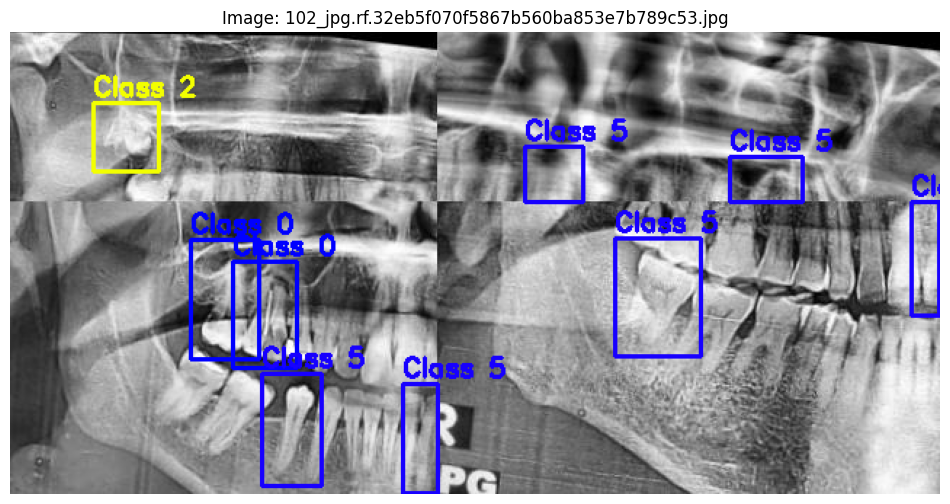


Visualizing: 101_jpg.rf.49ee594f213c1aa8cb8181f095b927ab.jpg
Image dimensions (HxW): 349 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels/101_jpg.rf.49ee594f213c1aa8cb8181f095b927ab.txt
Number of bounding boxes (lines): 13
  - Line 1: Class=5, CenterX=0.3935, CenterY=0.2521, Width=0.0738, Height=0.2788
  - Line 2: Class=0, CenterX=0.1833, CenterY=0.3278, Width=0.0699, Height=0.2156
  - Line 3: Class=0, CenterX=0.1333, CenterY=0.3248, Width=0.0745, Height=0.2130
  - Line 4: Class=5, CenterX=0.4334, CenterY=0.5066, Width=0.0575, Height=0.2235
  - Line 5: Class=4, CenterX=0.8853, CenterY=0.1426, Width=0.0653, Height=0.2268
Drawn 13 bounding boxes.


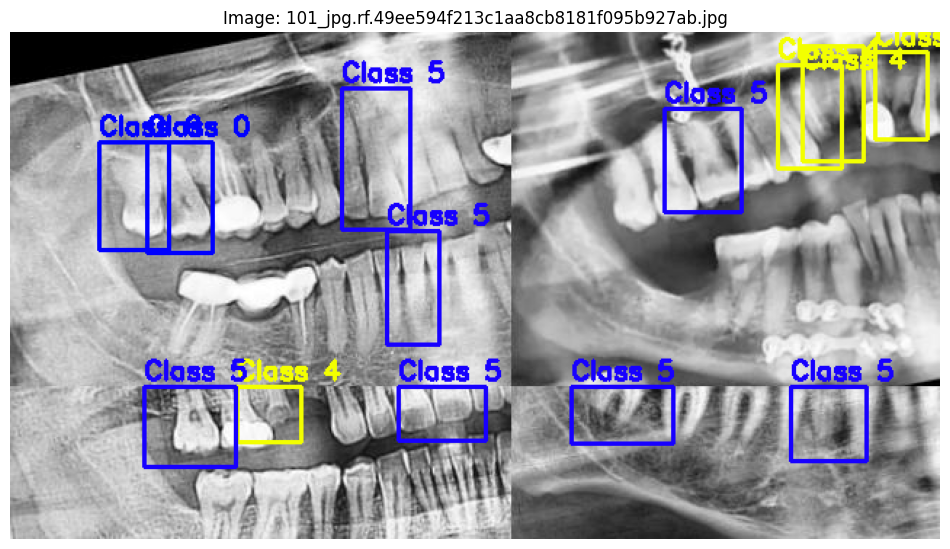


--- Visualizing Validation Samples ---

Visualizing: 234_jpg.rf.7aa3282a6d1f46ccf818bf47138da199.jpg
Image dimensions (HxW): 277 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/labels/234_jpg.rf.7aa3282a6d1f46ccf818bf47138da199.txt
Number of bounding boxes (lines): 5
  - Line 1: Class=5, CenterX=0.2969, CenterY=0.4079, Width=0.0594, Height=0.3249
  - Line 2: Class=5, CenterX=0.1938, CenterY=0.6029, Width=0.0734, Height=0.2383
  - Line 3: Class=5, CenterX=0.5078, CenterY=0.7509, Width=0.0344, Height=0.2274
  - Line 4: Class=5, CenterX=0.7922, CenterY=0.3682, Width=0.0594, Height=0.2274
  - Line 5: Class=5, CenterX=0.7453, CenterY=0.6787, Width=0.0891, Height=0.2455
Drawn 5 bounding boxes.


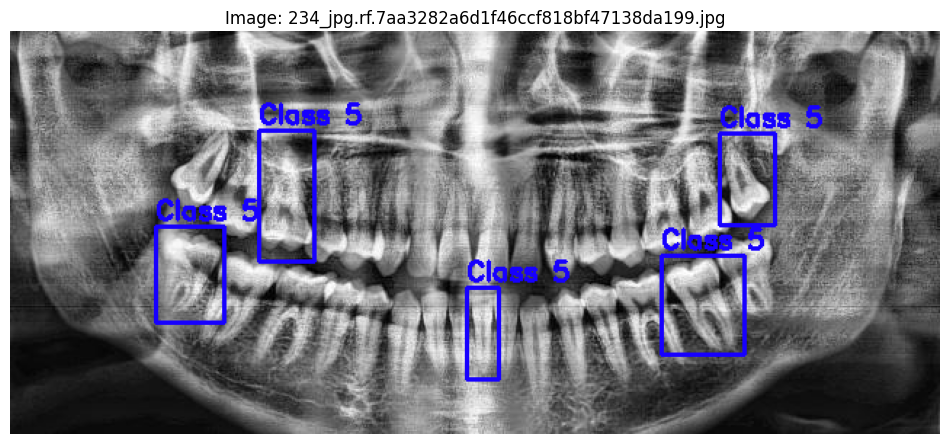


Visualizing: 43_jpg.rf.248120e1dc6d0582bb6059cb0a5edbd9.jpg
Image dimensions (HxW): 358 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/labels/43_jpg.rf.248120e1dc6d0582bb6059cb0a5edbd9.txt
Number of bounding boxes (lines): 6
  - Line 1: Class=5, CenterX=0.3234, CenterY=0.5531, Width=0.0641, Height=0.2737
  - Line 2: Class=4, CenterX=0.1688, CenterY=0.7849, Width=0.0516, Height=0.1369
  - Line 3: Class=0, CenterX=0.7719, CenterY=0.6173, Width=0.0922, Height=0.2877
  - Line 4: Class=0, CenterX=0.2578, CenterY=0.8017, Width=0.0656, Height=0.2263
  - Line 5: Class=0, CenterX=0.1703, CenterY=0.6089, Width=0.0656, Height=0.2402
Drawn 6 bounding boxes.


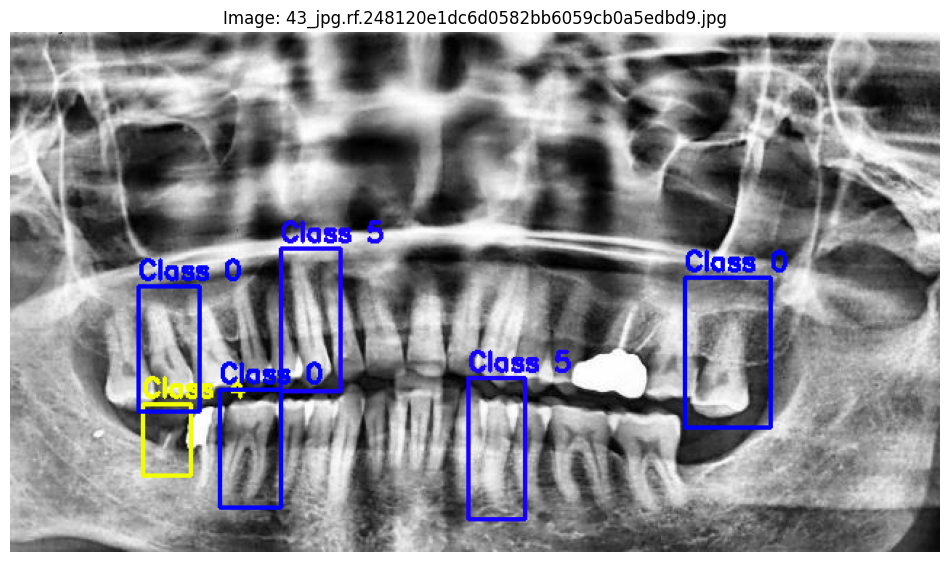


--- Visualizing Test Samples ---

Visualizing: 166_jpg.rf.f39fc4b554ab515d8114483ab2ae5f7e.jpg
Image dimensions (HxW): 332 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/labels/166_jpg.rf.f39fc4b554ab515d8114483ab2ae5f7e.txt
Number of bounding boxes (lines): 9
  - Line 1: Class=5, CenterX=0.2969, CenterY=0.7440, Width=0.0719, Height=0.2560
  - Line 2: Class=2, CenterX=0.1734, CenterY=0.4669, Width=0.0672, Height=0.1506
  - Line 3: Class=2, CenterX=0.8250, CenterY=0.4699, Width=0.0781, Height=0.1657
  - Line 4: Class=0, CenterX=0.8406, CenterY=0.6867, Width=0.1016, Height=0.1446
  - Line 5: Class=2, CenterX=0.8359, CenterY=0.6898, Width=0.1031, Height=0.1446
Drawn 9 bounding boxes.


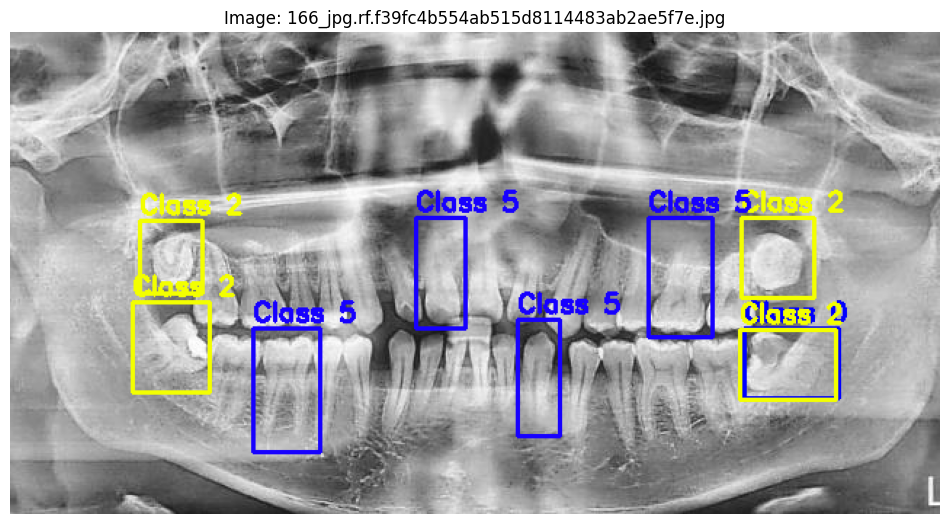


Visualizing: 127_jpg.rf.c6c7a6eea86965354399e338b71fbc6a.jpg
Image dimensions (HxW): 274 x 640

Examining: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/labels/127_jpg.rf.c6c7a6eea86965354399e338b71fbc6a.txt
Number of bounding boxes (lines): 7
  - Line 1: Class=5, CenterX=0.4141, CenterY=0.6423, Width=0.0563, Height=0.3139
  - Line 2: Class=5, CenterX=0.7031, CenterY=0.3686, Width=0.0734, Height=0.2628
  - Line 3: Class=0, CenterX=0.2562, CenterY=0.6569, Width=0.0750, Height=0.2956
  - Line 4: Class=5, CenterX=0.4922, CenterY=0.3540, Width=0.0437, Height=0.2628
  - Line 5: Class=5, CenterX=0.5359, CenterY=0.6204, Width=0.0406, Height=0.3212
Drawn 7 bounding boxes.


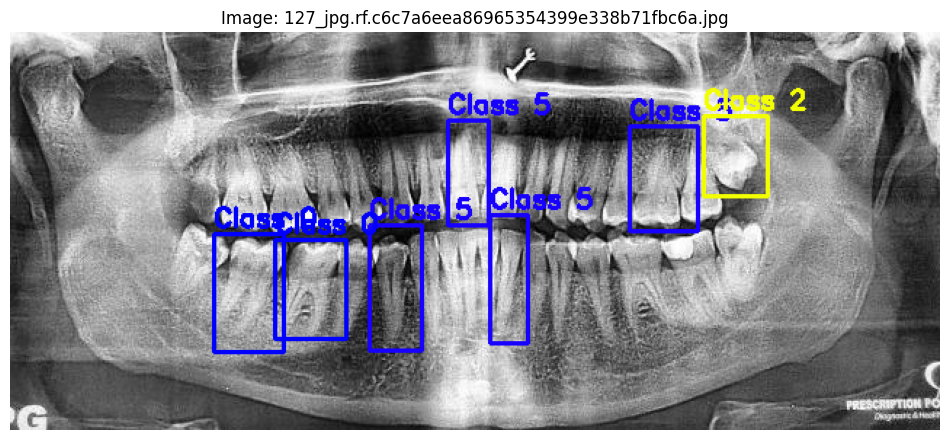

In [6]:
def display_image_with_boxes(image_path, label_path, num_samples=1):
    """Loads an image and its corresponding YOLO detection label, then displays them."""
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return
    if not os.path.exists(label_path):
        print(f"Label file not found: {label_path}")
        # Optionally display the image without boxes if label is missing
        # img = cv2.imread(image_path)
        # if img is not None:
        #     plt.figure(figsize=(10, 7))
        #     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #     plt.title(f"Image: {os.path.basename(image_path)} (No Label Found)")
        #     plt.axis('off')
        #     plt.show()
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read image: {image_path}")
        return

    img_h, img_w = img.shape[:2]
    img_display = img.copy() # Work on a copy

    print(f"\nVisualizing: {os.path.basename(image_path)}")
    print(f"Image dimensions (HxW): {img_h} x {img_w}")

    lines_info = examine_label_file_detection(label_path) # Use updated examination function

    if lines_info is None or not lines_info:
        print("No valid bounding boxes found or error reading label file.")
    else:
        # Generate distinct colors for classes
        valid_classes = [info['class'] for info in lines_info if info['valid']]
        unique_classes = sorted(list(set(valid_classes))) if valid_classes else []
        # Use a colormap suitable for potentially many classes
        colors = plt.cm.get_cmap('hsv', len(unique_classes) if unique_classes else 1)
        class_colors = {cls: tuple(int(c*255) for c in colors(i)[:3]) for i, cls in enumerate(unique_classes)} # BGR for OpenCV

        box_count = 0
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5: continue # Skip invalid lines

                try:
                    class_id = int(parts[0])
                    cx = float(parts[1])
                    cy = float(parts[2])
                    w = float(parts[3])
                    h = float(parts[4])

                    # Denormalize coordinates and dimensions
                    center_x_abs = cx * img_w
                    center_y_abs = cy * img_h
                    box_w_abs = w * img_w
                    box_h_abs = h * img_h

                    # Calculate top-left (x1, y1) and bottom-right (x2, y2) coordinates
                    x1 = int(center_x_abs - box_w_abs / 2)
                    y1 = int(center_y_abs - box_h_abs / 2)
                    x2 = int(center_x_abs + box_w_abs / 2)
                    y2 = int(center_y_abs + box_h_abs / 2)

                    # Ensure coordinates are within image bounds (important for drawing)
                    x1 = max(0, x1)
                    y1 = max(0, y1)
                    x2 = min(img_w - 1, x2)
                    y2 = min(img_h - 1, y2)

                    color = class_colors.get(class_id, (0, 0, 255)) # Default to red if class not found
                    label_text = f"Class {class_id}" # You might want to map this to actual names later

                    # Draw the bounding box rectangle
                    cv2.rectangle(img_display, (x1, y1), (x2, y2), color, thickness=2)
                    # Add class label text above the box
                    cv2.putText(img_display, label_text, (x1, y1 - 5 if y1 > 10 else y1 + 15),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

                    box_count += 1

                except Exception as e:
                    print(f"Error processing line for drawing: {line.strip()} - {e}")
        print(f"Drawn {box_count} bounding boxes.")


    # Display using Matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for plt
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

# Get lists of files (Keep as before)
train_image_files = sorted(glob.glob(os.path.join(TRAIN_IMG_DIR, '*.jpg')))
valid_image_files = sorted(glob.glob(os.path.join(VALID_IMG_DIR, '*.jpg')))
test_image_files = sorted(glob.glob(os.path.join(TEST_IMG_DIR, '*.jpg')))

# Visualize a few samples from each split (Use updated function name)
num_samples_to_show = 2

print("\n--- Visualizing Training Samples ---")
for i in range(min(num_samples_to_show, len(train_image_files))):
    idx = random.randint(0, len(train_image_files)-1) # Pick random samples
    img_file = train_image_files[idx]
    lbl_file = os.path.join(TRAIN_LBL_DIR, os.path.basename(img_file).replace('.jpg', '.txt'))
    display_image_with_boxes(img_file, lbl_file) # Use updated function

print("\n--- Visualizing Validation Samples ---")
for i in range(min(num_samples_to_show, len(valid_image_files))):
    idx = random.randint(0, len(valid_image_files)-1)
    img_file = valid_image_files[idx]
    lbl_file = os.path.join(VALID_LBL_DIR, os.path.basename(img_file).replace('.jpg', '.txt'))
    display_image_with_boxes(img_file, lbl_file) # Use updated function

print("\n--- Visualizing Test Samples ---")
for i in range(min(num_samples_to_show, len(test_image_files))):
    idx = random.randint(0, len(test_image_files)-1)
    img_file = test_image_files[idx]
    lbl_file = os.path.join(TEST_LBL_DIR, os.path.basename(img_file).replace('.jpg', '.txt'))
    display_image_with_boxes(img_file, lbl_file) # Use updated function



## Step 4: Basic Statistics

In [7]:
image_widths = []
image_heights = []
boxes_per_image = [] # Changed name from segments_per_image
all_class_ids = set()
empty_label_files = 0

train_label_files = sorted(glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt')))

for lbl_file in train_label_files:
    img_file = os.path.join(TRAIN_IMG_DIR, os.path.basename(lbl_file).replace('.txt', '.jpg'))

    if not os.path.exists(img_file):
        print(f"Warning: Corresponding image not found for label {lbl_file}")
        continue

    # Image dimensions (Keep as before)
    try:
        # Optimization: Use cv2.imread only once if needed for both stats and visualization later
        # Or use a library like PIL to get dimensions without loading the full image if memory is a concern
        img = cv2.imread(img_file)
        if img is not None:
            h, w = img.shape[:2]
            image_heights.append(h)
            image_widths.append(w)
        else:
            print(f"Warning: Could not read image {img_file}")
            continue
    except Exception as e:
        print(f"Error reading image {img_file}: {e}")
        continue

    # Label info (Logic adapted for detection format)
    try:
        with open(lbl_file, 'r') as f:
            lines = f.readlines()

        num_boxes = 0
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5: # Check for valid detection line format
                num_boxes += 1
                try:
                    all_class_ids.add(int(parts[0]))
                except ValueError:
                    print(f"Warning: Non-integer class ID found in {lbl_file}: {parts[0]}")
            elif parts: # If line is not empty but has wrong format
                 print(f"Warning: Invalid line format in {lbl_file}: '{line.strip()}'")


        boxes_per_image.append(num_boxes)

        if num_boxes == 0 and lines: # Label file exists but has no valid lines or is empty
             print(f"Warning: Label file {lbl_file} seems empty or contains only invalid lines.")
             if not lines:
                 empty_label_files += 1 # Count files that are truly empty


    except Exception as e:
        print(f"Error reading or processing label file {lbl_file}: {e}")

# Summary (Keep variable names consistent)
print(f"\nStatistics based on {len(train_label_files)} training labels:")
if image_widths:
    print(f"Image Widths: Min={np.min(image_widths)}, Max={np.max(image_widths)}, Avg={np.mean(image_widths):.2f}")
    print(f"Image Heights: Min={np.min(image_heights)}, Max={np.max(image_heights)}, Avg={np.mean(image_heights):.2f}")
    # Consider plotting histograms if needed
    # plt.figure(figsize=(10, 4))
    # plt.subplot(1, 2, 1)
    # plt.hist(image_widths, bins=20)
    # plt.title('Image Width Distribution (Train)')
    # plt.subplot(1, 2, 2)
    # plt.hist(image_heights, bins=20)
    # plt.title('Image Height Distribution (Train)')
    # plt.tight_layout()
    # plt.show()

if boxes_per_image:
    print(f"Bounding Boxes per Image: Min={np.min(boxes_per_image)}, Max={np.max(boxes_per_image)}, Avg={np.mean(boxes_per_image):.2f}")
    print(f"Number of completely empty label files: {empty_label_files}") # Clarified meaning
    # Consider plotting histogram
    # plt.figure(figsize=(6, 4))
    # plt.hist(boxes_per_image, bins=max(10, np.max(boxes_per_image) // 2 if np.max(boxes_per_image) > 0 else 10)) # Adjust bins
    # plt.title('Boxes per Image Distribution (Train)')
    # plt.show()

print(f"Unique Class IDs found: {sorted(list(all_class_ids))}")
if len(all_class_ids) > 0:
    print(f"This confirms a detection task with {len(all_class_ids)} classes.")
    print("You will need to define the names for these classes in your dataset.yaml file.")
else:
     print("Warning: No valid class IDs were found in the training labels.")




Statistics based on 558 training labels:
Image Widths: Min=639, Max=640, Avg=639.99
Image Heights: Min=250, Max=485, Avg=349.64
Bounding Boxes per Image: Min=1, Max=25, Avg=10.11
Number of completely empty label files: 0
Unique Class IDs found: [0, 1, 2, 3, 4, 5]
This confirms a detection task with 6 classes.
You will need to define the names for these classes in your dataset.yaml file.


## Step 5: Create Dataset.yaml File

In [8]:
dataset_yaml_content = f"""
path: {os.path.abspath(INPUT_DATA_DIR)} # Absolute path can sometimes be more reliable inside the library
train: {os.path.abspath(TRAIN_IMG_DIR_REL)} # Path to train images
val: {os.path.abspath(VALID_IMG_DIR_REL)}   # Path to validation images
test: {os.path.abspath(TEST_IMG_DIR_REL)}  # Path to test images (optional)

# Classes
nc: {num_classes}
names: {class_names}
"""

# Write the content to the YAML file
os.makedirs(YAML_DIR, exist_ok=True) # Ensure the directory exists
with open(yaml_file_path, 'w') as f:
    f.write(dataset_yaml_content)

print(f"--- dataset.yaml created at: {yaml_file_path} ---")
print("Content:")
print(dataset_yaml_content)
print("-" * 30)

--- dataset.yaml created at: /kaggle/working/dental_opg_dataset.yaml ---
Content:

path: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data # Absolute path can sometimes be more reliable inside the library
train: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/images # Path to train images
val: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/images   # Path to validation images
test: /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/images  # Path to test images (optional)

# Classes
nc: 6
names: ['Caries', 'Infection', 'Impacted Teeth', 'Fractured Teeth', 'Broken Crown', 'Healthy']

------------------------------


## Step 6: Configure Training Parameters

In [9]:
model_name = 'yolov10l.pt'

# Training hyperparameters
EPOCHS = 200  # Start with a reasonable number, can adjust based on val performance
IMG_SIZE = 640 # Input images will be resized to this (common default, matches data width)
BATCH_SIZE = 4 # Adjust based on GPU memory (16 is usually okay for T4/P100 with yolov8m)
PATIENCE = 30 # Early stopping patience: stops training if no improvement after 'patience' epochs
PROJECT_NAME = 'Dental_OPG_Detection' # Directory to save runs
RUN_NAME = 'yolov10l_e200_batch4' # Specific name for this training run

# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cpu':
    print("WARNING: Training on CPU will be very slow. Ensure GPU is enabled in Kaggle settings.")
    # Consider reducing batch size or using a smaller model (yolov8n) if stuck on CPU
    # BATCH_SIZE = max(2, BATCH_SIZE // 4) # Example adjustment for CPU

Using device: cuda


## Step 7: Initialize and Train the Model

In [10]:
print(f"\n--- Initializing YOLO model: {model_name} ---")
model = YOLO(model_name)

print(f"\n--- Starting Training ---")
print(f"   Data YAML: {yaml_file_path}")
print(f"   Epochs: {EPOCHS}")
print(f"   Image Size: {IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Patience: {PATIENCE}")
print(f"   Project: {PROJECT_NAME}")
print(f"   Run Name: {RUN_NAME}")
print("-" * 30)


--- Initializing YOLO model: yolov10l.pt ---


100%|██████████| 50.0M/50.0M [00:00<00:00, 201MB/s]



--- Starting Training ---
   Data YAML: /kaggle/working/dental_opg_dataset.yaml
   Epochs: 200
   Image Size: 640
   Batch Size: 4
   Patience: 30
   Project: Dental_OPG_Detection
   Run Name: yolov10l_e200_batch4
------------------------------


In [11]:
# Start training
try:
    results = model.train(
        data=yaml_file_path,
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        patience=PATIENCE,
        device=device,          # Explicitly set device
        project=PROJECT_NAME,   # Saves runs to /kaggle/working/Dental_OPG_Detection/
        name=RUN_NAME,          # Subdirectory name within the project folder
        exist_ok=False,         # Set to True if you want to overwrite previous runs with the same name
        # Augmentation parameters can be adjusted here if needed, defaults are usually good.
        # e.g., degrees=10, translate=0.1, scale=0.1, flipud=0.5 ...
        cache=True, # Cache images in RAM for faster training (if RAM allows)
    )
    print("\n--- Training Completed Successfully ---")

except Exception as e:
    print(f"\n--- Training Interrupted/Failed ---")
    print(f"Error: {e}")

Ultralytics 8.3.124 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10l.pt, data=/kaggle/working/dental_opg_dataset.yaml, epochs=200, time=None, patience=30, batch=4, imgsz=640, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=Dental_OPG_Detection, name=yolov10l_e200_batch4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

train: Scanning /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train/labels... 558 images, 9 backgrounds, 0 corrupt: 100%|██████████| 567/567 [00:00<00:00, 1003.50it/s]

WARNING ⚠️ train: Cache directory /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/train is not writeable, cache not saved.


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.4GB RAM): 100%|██████████| 567/567 [00:00<00:00, 1048.15it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.4±0.9 ms, read: 92.6±23.3 MB/s, size: 48.0 KB)


val: Scanning /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 375.09it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/valid is not writeable, cache not saved.
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 23/23 [00:00<00:00, 534.64it/s]


Plotting labels to Dental_OPG_Detection/yolov10l_e200_batch4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 167 weight(decay=0.0), 180 weight(decay=0.0005), 179 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to Dental_OPG_Detection/yolov10l_e200_batch4
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200       3.6G      3.541      5.464      3.173         41        640: 100%|██████████| 142/142 [00:36<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.54it/s]

                   all         23        115      0.225      0.289      0.268      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      3.78G      2.929      3.035      2.773         77        640: 100%|██████████| 142/142 [00:35<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.25it/s]

                   all         23        115      0.448      0.316      0.358      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      3.78G       2.79      2.723      2.685         58        640: 100%|██████████| 142/142 [00:37<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.97it/s]

                   all         23        115      0.399       0.39      0.371      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      3.78G      2.726      2.482      2.649         46        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.12it/s]

                   all         23        115      0.413      0.318       0.37       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      3.78G      2.406       2.18      2.473         20        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.84it/s]

                   all         23        115      0.431      0.352       0.39      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      3.78G      2.274      2.009      2.387         39        640: 100%|██████████| 142/142 [00:37<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]

                   all         23        115      0.495      0.402      0.403      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      3.78G       2.09       1.79      2.304         62        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.12it/s]

                   all         23        115      0.501      0.387      0.418       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      3.78G      2.077      1.679      2.278         53        640: 100%|██████████| 142/142 [00:37<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.96it/s]

                   all         23        115      0.445      0.423      0.448       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      3.78G       2.09      1.663      2.321         43        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         23        115      0.511      0.368      0.467      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      3.78G      1.925      1.608       2.22         92        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.00it/s]

                   all         23        115      0.615      0.413      0.454      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      3.78G      1.861      1.538      2.198         49        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         23        115      0.604      0.373      0.448       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      3.78G       1.87      1.488      2.184         28        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]

                   all         23        115      0.483      0.461      0.482      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      3.78G      1.823      1.481      2.156         45        640: 100%|██████████| 142/142 [00:37<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all         23        115      0.726      0.428      0.457      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      3.78G      1.725      1.401      2.134         56        640: 100%|██████████| 142/142 [00:37<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

                   all         23        115      0.426      0.499      0.458      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      3.78G      1.747        1.4      2.121         58        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.541      0.446      0.477      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      3.78G      1.743      1.365      2.108         74        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.94it/s]

                   all         23        115      0.501      0.484      0.492      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      3.78G      1.616      1.267      2.051         36        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]

                   all         23        115      0.617      0.467      0.515      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      3.79G      1.522      1.195      2.033         48        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.79it/s]

                   all         23        115      0.707      0.434      0.513      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      3.79G      1.602      1.263      2.078         29        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.03it/s]

                   all         23        115       0.46        0.5      0.546      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.79G      1.521      1.173      2.032         34        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]

                   all         23        115      0.576      0.585      0.597      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.79G      1.575      1.222       2.05         37        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.626      0.456      0.559      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      3.79G      1.556      1.226      2.045         54        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         23        115      0.599      0.444      0.563       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      3.79G      1.515       1.14      2.007         89        640: 100%|██████████| 142/142 [00:37<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         23        115      0.596      0.489      0.546      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.79G       1.46      1.141      2.001         61        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.04it/s]

                   all         23        115      0.532      0.531      0.579      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      3.79G       1.42      1.084      1.972         50        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.01it/s]

                   all         23        115      0.672       0.56      0.612       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      3.79G      1.396      1.051      1.985         25        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.658      0.504      0.556       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      3.79G      1.384      1.058      1.967         49        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.47it/s]

                   all         23        115      0.602      0.476      0.539      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      3.79G      1.409      1.079      1.996         70        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.03it/s]

                   all         23        115      0.585      0.594      0.607      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.79G      1.429       1.06      1.983         50        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]

                   all         23        115      0.638        0.6      0.637      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      3.79G      1.397      1.032      1.982         37        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.04it/s]

                   all         23        115      0.729      0.559       0.63      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      3.79G      1.377      1.036      1.999         45        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         23        115      0.658      0.565      0.597      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      3.79G      1.365     0.9921      1.952         31        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]

                   all         23        115      0.698      0.576      0.621      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      3.79G      1.404      1.007      1.964         52        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.657      0.572      0.617      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      3.79G      1.335     0.9505      1.943         73        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.19it/s]

                   all         23        115      0.754      0.681      0.729      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      3.79G      1.271     0.9092      1.933         50        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.04it/s]

                   all         23        115      0.671      0.719      0.718      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      3.79G      1.306     0.9297      1.924         67        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.98it/s]

                   all         23        115      0.626      0.674      0.683      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      3.79G      1.288     0.9194      1.936         53        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.688      0.738      0.715      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      3.79G      1.306     0.9296      1.934         45        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         23        115       0.75      0.668        0.7      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      3.79G       1.27     0.9069      1.903         44        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         23        115       0.73      0.627      0.676      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      3.79G      1.257     0.8646      1.891         71        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         23        115      0.669      0.613       0.66      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      3.79G      1.239     0.8644       1.88         65        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.567       0.57      0.627      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      3.79G      1.231     0.8695      1.902         55        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         23        115      0.652      0.715      0.712      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      3.79G      1.234     0.8549      1.888         77        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]

                   all         23        115      0.751      0.636      0.695      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      3.79G      1.252     0.8777      1.908         24        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.19it/s]

                   all         23        115      0.664      0.608      0.661       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      3.79G      1.264     0.8781       1.92         34        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.72it/s]

                   all         23        115      0.643      0.649      0.668      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      3.79G      1.237     0.8649      1.897         45        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         23        115      0.697      0.594      0.655      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      3.79G      1.203     0.8262      1.859         54        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]

                   all         23        115      0.732      0.679      0.723      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      3.79G       1.22     0.8289      1.885         54        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.20it/s]

                   all         23        115      0.643      0.689      0.693      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      3.79G      1.215     0.8483      1.877         76        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all         23        115      0.686      0.684      0.705      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      3.79G      1.197     0.8318      1.892         46        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.12it/s]

                   all         23        115      0.789      0.691      0.714        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      3.79G      1.196     0.8162      1.875         30        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.20it/s]

                   all         23        115      0.781      0.615      0.697      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      3.79G      1.195     0.7834      1.882         52        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all         23        115      0.793      0.706      0.743      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      3.79G      1.116     0.7387      1.832         87        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all         23        115      0.774      0.715      0.722      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      3.79G      1.114     0.7164      1.861         70        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.94it/s]

                   all         23        115      0.792      0.704      0.766      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.79G      1.138       0.76      1.846         89        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]

                   all         23        115      0.687      0.733      0.706      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      3.79G      1.126     0.7428       1.83         67        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         23        115      0.652       0.79      0.727      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      3.79G      1.144     0.7569      1.853         70        640: 100%|██████████| 142/142 [00:37<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.82it/s]

                   all         23        115      0.745      0.748      0.734      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      3.79G      1.096     0.7203      1.852        101        640: 100%|██████████| 142/142 [00:37<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

                   all         23        115      0.657      0.728      0.726      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      3.79G      1.113     0.7089      1.848         37        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.15it/s]

                   all         23        115      0.683      0.711       0.72      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      3.79G      1.124      0.721      1.839         54        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]

                   all         23        115      0.686      0.799      0.735      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      3.79G      1.122     0.7145      1.857         56        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

                   all         23        115      0.706      0.777      0.738      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      3.79G      1.085     0.7075      1.854         21        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.15it/s]

                   all         23        115      0.788      0.778      0.763      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      3.79G      1.047     0.6902      1.823         64        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.72it/s]

                   all         23        115      0.676      0.718      0.728      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      3.79G      1.073     0.6922      1.835         47        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         23        115      0.879      0.679      0.752       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      3.79G      1.072     0.6971      1.814         39        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.774      0.664      0.753      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      3.79G      1.088     0.7144       1.82         60        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all         23        115      0.757       0.72      0.727      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      3.79G      1.082     0.6978      1.841         52        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.15it/s]

                   all         23        115      0.704      0.686      0.728      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      3.79G      1.061     0.6926      1.809         43        640: 100%|██████████| 142/142 [00:37<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]

                   all         23        115      0.655      0.766      0.754      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      3.79G       1.07     0.6877       1.83         47        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.25it/s]

                   all         23        115      0.734      0.796      0.776      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      3.79G      1.074     0.6971      1.816         33        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         23        115       0.75      0.741      0.768      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      3.79G      1.037      0.655      1.801         38        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all         23        115      0.752      0.711      0.798      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      3.79G      1.018     0.6296      1.806         65        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.86it/s]

                   all         23        115      0.775      0.741      0.798      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      3.79G      1.013     0.6481      1.803         59        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         23        115      0.696      0.725      0.777      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      3.79G      1.013     0.6164        1.8         32        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.24it/s]

                   all         23        115      0.767      0.668       0.74      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      3.79G      1.066     0.6467      1.816         68        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.723      0.761      0.735      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      3.79G       1.01     0.6188      1.795         45        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         23        115      0.865      0.663       0.78      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      3.79G       0.99      0.613      1.803         41        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.12it/s]

                   all         23        115      0.778       0.65       0.74      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      3.79G      1.001     0.6277      1.788         87        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.21it/s]

                   all         23        115      0.739      0.738      0.782      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      3.79G     0.9822     0.6386      1.801         49        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.758      0.691      0.739      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      3.79G     0.9661     0.5943      1.779         22        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         23        115      0.734      0.778      0.773      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      3.79G     0.9837      0.608      1.794         29        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.86it/s]

                   all         23        115      0.764      0.729      0.774      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      3.79G      0.972     0.6116      1.766         33        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.04it/s]

                   all         23        115      0.727      0.751      0.776      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      3.79G     0.9746     0.6127       1.78         51        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

                   all         23        115      0.719      0.688      0.724       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      3.79G     0.9944      0.626      1.798         52        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all         23        115      0.778      0.746      0.778      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      3.79G     0.9704     0.5955      1.784         23        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]

                   all         23        115      0.801      0.688       0.79      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      3.79G     0.9594     0.5821      1.781         55        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.25it/s]

                   all         23        115      0.717      0.744      0.764      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      3.79G     0.9436     0.5762      1.767         61        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

                   all         23        115      0.756      0.738       0.76       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      3.79G     0.9147     0.5545      1.771         48        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.829      0.712      0.766      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      3.79G     0.9175     0.5792      1.768         70        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

                   all         23        115      0.742      0.749      0.799      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      3.79G     0.9275      0.562      1.781         62        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all         23        115      0.768      0.721      0.778      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      3.79G     0.9584     0.5775      1.787         37        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.91it/s]

                   all         23        115      0.768       0.74      0.786       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      3.79G      0.933     0.5571      1.784         33        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.23it/s]

                   all         23        115      0.856      0.706      0.828      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      3.79G     0.9468     0.5651      1.779         57        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]

                   all         23        115      0.863      0.734      0.819      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      3.79G     0.9069     0.5485      1.766         64        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.884      0.742      0.827      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      3.79G     0.9199     0.5463      1.755         42        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]

                   all         23        115      0.835      0.741      0.821      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      3.79G       0.94     0.5843      1.793         65        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all         23        115      0.852      0.775      0.841      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      3.79G      0.901     0.5379      1.763        102        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         23        115      0.846      0.795      0.846      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      3.79G     0.9294      0.565      1.782         44        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.15it/s]

                   all         23        115      0.886      0.757      0.845      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      3.79G     0.9106     0.5547      1.762         68        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.12it/s]

                   all         23        115      0.833      0.744      0.835      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      3.79G     0.8963      0.528      1.754         54        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]

                   all         23        115      0.868      0.753      0.822      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      3.79G     0.8702     0.5293       1.76         36        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.741       0.82      0.812      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      3.79G      0.903     0.5358      1.748         40        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]

                   all         23        115      0.844       0.76      0.817       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      3.79G     0.8959     0.5465      1.755         49        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]

                   all         23        115      0.817      0.754      0.802        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      3.79G     0.9062       0.53      1.765         54        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.15it/s]

                   all         23        115      0.773      0.746      0.803      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      3.79G     0.8621     0.5234      1.746         43        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

                   all         23        115      0.797      0.785      0.817      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      3.79G     0.8503     0.5155      1.744         58        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.759      0.779      0.798      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      3.79G     0.8606     0.5232      1.748         54        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]

                   all         23        115      0.819      0.763      0.824      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      3.79G     0.8636     0.5213      1.759         89        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]

                   all         23        115      0.851      0.714      0.807      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      3.79G     0.8755     0.5184      1.736         62        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         23        115      0.785      0.745      0.762      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      3.79G     0.8284     0.4934      1.731         23        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]

                   all         23        115       0.88      0.758      0.826      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      3.79G     0.8387     0.5163      1.728         95        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]

                   all         23        115        0.9      0.718      0.819      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      3.79G     0.8304     0.4862      1.733         57        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.94it/s]

                   all         23        115      0.887      0.732      0.814      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      3.79G     0.8285     0.4942      1.735         65        640: 100%|██████████| 142/142 [00:37<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.12it/s]

                   all         23        115      0.896      0.723      0.812      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      3.79G      0.828     0.4822      1.725         38        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.02it/s]

                   all         23        115      0.743      0.806      0.801      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      3.79G     0.8114     0.4856      1.728         70        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.834      0.752      0.787      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      3.79G      0.817     0.4798      1.732         54        640: 100%|██████████| 142/142 [00:37<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]

                   all         23        115      0.734      0.779      0.779      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      3.79G     0.8677     0.5162      1.745         77        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]

                   all         23        115      0.754      0.779      0.793      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      3.79G     0.8069      0.488       1.71         61        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.99it/s]

                   all         23        115      0.819      0.806      0.814      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      3.79G     0.8066     0.4908      1.729         36        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.12it/s]

                   all         23        115        0.8       0.79      0.822      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      3.79G      0.776     0.4626      1.719         73        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.95it/s]

                   all         23        115       0.82      0.727      0.829      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      3.79G     0.7932     0.4612      1.713         32        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all         23        115      0.809      0.766      0.817      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      3.79G      0.798     0.4667      1.708         59        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.18it/s]

                   all         23        115      0.903      0.727      0.839      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      3.79G     0.7917     0.4523      1.704         30        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]

                   all         23        115      0.817      0.782      0.834      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      3.79G     0.8007     0.4833      1.722         34        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.12it/s]

                   all         23        115      0.862      0.777      0.846      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      3.79G      0.787     0.4614      1.724         36        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         23        115      0.902      0.773      0.831      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      3.79G     0.7745     0.4516      1.701         51        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]

                   all         23        115      0.858      0.784      0.837      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      3.79G     0.7704     0.4704      1.713         69        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.18it/s]

                   all         23        115      0.835      0.787      0.825      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      3.79G     0.7839       0.46      1.702         22        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.20it/s]

                   all         23        115      0.873      0.747      0.829      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      3.79G     0.7818     0.4679      1.717         58        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.19it/s]

                   all         23        115      0.899      0.747      0.839      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      3.79G     0.7655     0.4404      1.711         28        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         23        115      0.857      0.754      0.838      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      3.79G     0.7763     0.4574      1.713         27        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.855      0.783      0.839      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      3.79G     0.7567     0.4556      1.701         30        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.846      0.762      0.823      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      3.79G     0.7543     0.4505      1.706         52        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all         23        115      0.821      0.791      0.843       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      3.79G     0.7772      0.451      1.704         52        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.12it/s]

                   all         23        115      0.806        0.8      0.841      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      3.79G     0.7923     0.4598      1.712        101        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.18it/s]

                   all         23        115       0.79      0.787      0.836      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      3.79G     0.7349     0.4398      1.697         53        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         23        115      0.785      0.834      0.857      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      3.79G     0.7391      0.438      1.688         81        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all         23        115      0.774      0.785      0.826       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      3.79G     0.7271      0.422      1.691         62        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.18it/s]

                   all         23        115      0.754      0.797      0.825       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      3.79G     0.7342     0.4451      1.707         60        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.02it/s]

                   all         23        115      0.911      0.724       0.84      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      3.79G     0.7322     0.4304      1.697         60        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.96it/s]

                   all         23        115      0.885      0.729      0.823      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      3.79G     0.7183     0.4184      1.694         47        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.19it/s]

                   all         23        115      0.803      0.792      0.825      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      3.79G     0.7563     0.4656      1.715         58        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.12it/s]

                   all         23        115      0.812      0.786      0.823      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      3.79G     0.7169     0.4273      1.695         49        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.869      0.784      0.847      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      3.79G     0.7293     0.4131      1.683         26        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all         23        115      0.806      0.775      0.863      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      3.79G     0.7351      0.424      1.692         55        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.809      0.779      0.838      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      3.79G     0.7394      0.429      1.687         23        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.12it/s]

                   all         23        115      0.806      0.776      0.828      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      3.79G     0.6893     0.4043      1.684         35        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

                   all         23        115      0.776      0.782      0.828      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      3.79G     0.7135     0.4161      1.697         32        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.15it/s]

                   all         23        115      0.841      0.759      0.838      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      3.79G     0.6806     0.4003      1.676         73        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.89it/s]

                   all         23        115      0.815      0.777      0.861      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      3.79G     0.6932     0.4102      1.695         66        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.19it/s]

                   all         23        115      0.779      0.788      0.821      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      3.79G     0.7001     0.4138      1.692         52        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.823      0.758      0.819      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      3.79G     0.6859     0.4006      1.675         43        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.832      0.716      0.809      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      3.79G     0.6649     0.3873      1.668         88        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]

                   all         23        115      0.816      0.741      0.822      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      3.79G      0.676     0.3916      1.679         25        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]

                   all         23        115      0.847      0.765      0.826      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      3.79G     0.6708     0.3748      1.683         65        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.833      0.776      0.842      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      3.79G     0.6937     0.4267      1.687         40        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.852      0.753      0.845      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      3.79G     0.7047     0.4158       1.69         82        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.22it/s]

                   all         23        115      0.837      0.772      0.839      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      3.79G     0.6649     0.3873      1.668         32        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]

                   all         23        115       0.82      0.764      0.856      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      3.79G     0.6494     0.3785      1.679         62        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         23        115      0.792      0.822      0.841      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      3.79G     0.6643     0.3782      1.672         49        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.02it/s]

                   all         23        115      0.834      0.772      0.834      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      3.79G     0.6678      0.388      1.675         44        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         23        115       0.86      0.737      0.835      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      3.79G     0.6551     0.3783      1.669         39        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.863      0.766      0.846      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      3.79G     0.6664     0.3866      1.671        106        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

                   all         23        115      0.874      0.746      0.838      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      3.79G     0.6269     0.3579      1.659         39        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

                   all         23        115      0.783      0.794      0.843      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      3.79G      0.632     0.3695      1.669         35        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.04it/s]

                   all         23        115      0.838      0.754      0.848      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      3.79G     0.6358     0.3721      1.659         37        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.19it/s]

                   all         23        115      0.841      0.744      0.854       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      3.79G     0.6385     0.3703      1.668         78        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.808      0.756      0.858       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      3.79G     0.6195     0.3599       1.66         58        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]

                   all         23        115      0.868      0.739      0.875      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      3.79G     0.6457     0.3757      1.673         73        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.823       0.78      0.853      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      3.79G     0.6181     0.3623      1.657         24        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.99it/s]

                   all         23        115      0.812      0.743      0.855      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      3.79G     0.6236     0.3536      1.666         65        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

                   all         23        115      0.807      0.786      0.849      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      3.79G      0.604     0.3578      1.647         48        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.847      0.779      0.845      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      3.79G      0.639     0.3573      1.656         47        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]

                   all         23        115      0.828      0.774      0.851       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      3.79G       0.61     0.3461      1.661         32        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.18it/s]

                   all         23        115       0.88      0.786      0.856      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      3.79G     0.6108     0.3561      1.657         57        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]

                   all         23        115       0.82      0.804      0.855      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      3.79G     0.6174     0.3547      1.664         55        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.00it/s]

                   all         23        115      0.782      0.811      0.854      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      3.79G       0.62     0.3532      1.655         68        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]

                   all         23        115       0.81      0.785      0.861      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      3.79G     0.6073     0.3494       1.64         70        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]

                   all         23        115      0.887      0.752       0.87      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      3.79G     0.6082     0.3574      1.657         45        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.863      0.748      0.858      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      3.79G     0.5721     0.3294      1.637         52        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.892      0.746      0.867      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      3.79G     0.5865     0.3371      1.647         49        640: 100%|██████████| 142/142 [00:37<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.894      0.736      0.866      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      3.79G     0.5936      0.344       1.66         56        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.873      0.735      0.863      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      3.79G     0.5708     0.3324      1.652         21        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]

                   all         23        115       0.85      0.735       0.85      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      3.79G     0.5868     0.3381      1.639         20        640: 100%|██████████| 142/142 [00:37<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         23        115       0.79      0.786       0.86      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      3.79G     0.5834     0.3304      1.654         40        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         23        115      0.804      0.775      0.851      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      3.79G     0.5744     0.3297      1.652         28        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.18it/s]

                   all         23        115      0.895      0.716      0.857      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      3.79G     0.5561     0.3198       1.65         80        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

                   all         23        115      0.833      0.777       0.85      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      3.79G     0.5661     0.3243      1.651         54        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         23        115      0.811      0.773      0.855      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      3.79G      0.572     0.3405      1.647         49        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.811       0.83      0.865      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      3.79G     0.5651     0.3327      1.639         39        640: 100%|██████████| 142/142 [00:37<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all         23        115      0.798       0.81      0.867       0.57


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      3.79G      1.336     0.6723      1.984         37        640: 100%|██████████| 142/142 [00:37<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.97it/s]

                   all         23        115      0.839       0.77      0.846      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      3.79G      1.294     0.6378      1.963         27        640: 100%|██████████| 142/142 [00:36<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.04it/s]

                   all         23        115      0.878      0.757      0.852      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      3.79G      1.262     0.6145      1.915         27        640: 100%|██████████| 142/142 [00:36<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all         23        115      0.808      0.803      0.873      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      3.79G      1.256     0.5906      1.915         36        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.817      0.805      0.864      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      3.79G      1.243     0.5959      1.923         34        640: 100%|██████████| 142/142 [00:36<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.15it/s]

                   all         23        115      0.832      0.802      0.864      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      3.79G      1.201     0.5892      1.897         27        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]

                   all         23        115      0.852      0.765      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      3.79G      1.194     0.5791      1.889         24        640: 100%|██████████| 142/142 [00:36<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.04it/s]

                   all         23        115      0.814      0.785      0.865      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      3.79G      1.157     0.5419      1.899         23        640: 100%|██████████| 142/142 [00:36<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         23        115      0.906      0.741      0.871      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      3.79G      1.156     0.5508      1.857         36        640: 100%|██████████| 142/142 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         23        115      0.858      0.781      0.874      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      3.79G      1.161      0.562      1.861         23        640: 100%|██████████| 142/142 [00:36<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.97it/s]

                   all         23        115       0.84      0.795       0.88       0.59



200 epochs completed in 2.146 hours.
Optimizer stripped from Dental_OPG_Detection/yolov10l_e200_batch4/weights/last.pt, 52.2MB
Optimizer stripped from Dental_OPG_Detection/yolov10l_e200_batch4/weights/best.pt, 52.2MB

Validating Dental_OPG_Detection/yolov10l_e200_batch4/weights/best.pt...
Ultralytics 8.3.124 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10l summary (fused): 174 layers, 24,313,954 parameters, 0 gradients, 120.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


                   all         23        115      0.841      0.795       0.88      0.589
                Caries          8         14      0.745      0.857      0.929      0.683
             Infection          3          4      0.549        0.5      0.606      0.386
        Impacted Teeth          7         18      0.972      0.889      0.987      0.633
       Fractured Teeth          3          3          1      0.976      0.995      0.643
          Broken Crown          6          9          1      0.937      0.995      0.632
               Healthy         22         67      0.778      0.612      0.769      0.556


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 13.8ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to Dental_OPG_Detection/yolov10l_e200_batch4

--- Training Completed Successfully ---


## Step8: Model Testing & Validation

In [12]:
import os
from ultralytics import YOLO
import torch

# --- 1. Define Paths and Parameters ---

# Reuse variables from the training script if possible, or redefine them
PROJECT_NAME = 'Dental_OPG_Detection'
RUN_NAME = 'yolov10l_e200_batch4' # Make sure this matches the run name used during training
MODEL_WEIGHTS_PATH = os.path.join('/kaggle/working/', PROJECT_NAME, RUN_NAME, 'weights', 'best.pt')
YAML_DIR = '/kaggle/working/' # Directory where the yaml file was saved
yaml_file_path = os.path.join(YAML_DIR, 'dental_opg_dataset.yaml')
IMG_SIZE = 640 # Use the same image size as during training

# Check if the model weights file exists
if not os.path.exists(MODEL_WEIGHTS_PATH):
    print(f"ERROR: Model weights not found at: {MODEL_WEIGHTS_PATH}")
    print("Please ensure the training completed successfully and the PROJECT_NAME/RUN_NAME are correct.")
    # You might need to list directories in /kaggle/working/ to find the correct path
    # import glob
    # print("Available runs:", glob.glob('/kaggle/working/Dental_OPG_Detection/*/weights/best.pt'))
else:
    print(f"Found model weights: {MODEL_WEIGHTS_PATH}")
    print(f"Using dataset configuration: {yaml_file_path}")

    # Check for GPU
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # --- 2. Load the Trained Model ---
    print("\n--- Loading trained model ---")
    model = YOLO(MODEL_WEIGHTS_PATH)

    # --- 3. Run Validation on the Test Set ---
    print(f"\n--- Evaluating model on the 'test' split ---")

    # The model.val() method runs evaluation
    # Setting split='test' tells it to use the 'test:' path from your dataset.yaml
    metrics = model.val(
        data=yaml_file_path,
        split='test',
        imgsz=IMG_SIZE,
        batch=4, # Adjust based on GPU memory if needed, should be fine for inference
        device=device,
        project=PROJECT_NAME, # Optional: Save results under the same project
        name=RUN_NAME + '_test_eval', # Optional: Give a specific name to this evaluation run
        save_json=True, # Save results statistics in JSON format (recommended)
        save_hybrid=False, # Saves labels with preds too - can be useful but creates many files
        conf=0.25, # Confidence threshold for evaluation (default 0.001, mAP uses thresholds internally anyway)
        iou=0.7 # IoU threshold for NMS - doesn't directly impact mAP calculation much but affects PR curve points
    )

    print("\n--- Evaluation Complete ---")

    # --- 4. Access and Display Metrics ---
    # The 'metrics' object holds the results. Key metrics are in metrics.box:
    print("\n--- Performance Metrics on Test Set ---")
    print(f"mAP50-95 (Primary Metric): {metrics.box.map:.4f}")
    print(f"mAP50 (IoU=0.50):         {metrics.box.map50:.4f}")
    print(f"mAP75 (IoU=0.75):         {metrics.box.map75:.4f}")
    print("-" * 20)
    # Precision and Recall are typically reported averaged over classes at the optimal F1 score threshold
    # Note: metrics.results_dict might contain per-class P, R, F1 if calculated,
    # but the main output usually focuses on mAP. The printed summary during execution shows P & R.
    # Or access them directly if needed (may vary slightly based on ultralytics version):
    try:
        precision = metrics.box.mp # Mean precision
        recall = metrics.box.mr    # Mean recall
        print(f"Mean Precision:           {precision:.4f}")
        print(f"Mean Recall:              {recall:.4f}")
    except AttributeError:
        print("Precision/Recall attributes (mp, mr) might not be directly available in this version.")
        print("Check the console output during model.val() execution for Precision and Recall values.")


    print("-" * 20)
    print("Per-class mAP50-95:")
    for i, name in enumerate(metrics.names.values()):
         print(f"  - {name}: {metrics.box.maps[i]:.4f}") # maps is the array of mAP50-95 per class

    print(f"\nEvaluation results saved in: /kaggle/working/{PROJECT_NAME}/{RUN_NAME}_test_eval")
    print("Check this directory for:")
    print("  - confusion_matrix.png")
    print("  - P_curve.png (Precision-Confidence curve)")
    print("  - R_curve.png (Recall-Confidence curve)")
    print("  - PR_curve.png (Precision-Recall curve)")
    print("  - F1_curve.png (F1-Confidence curve)")
    print("  - results.csv (Detailed metrics)")
    print("  - results.json (If save_json=True)")
    print("  - Images with predicted bounding boxes overlaid.")

Found model weights: /kaggle/working/Dental_OPG_Detection/yolov10l_e200_batch4/weights/best.pt
Using dataset configuration: /kaggle/working/dental_opg_dataset.yaml
Using device: cuda

--- Loading trained model ---

--- Evaluating model on the 'test' split ---
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.124 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10l summary (fused): 174 layers, 24,313,954 parameters, 0 gradients, 120.0 GFLOPs
val: Fast image access ✅ (ping: 1.5±0.3 ms, read: 85.6±10.5 MB/s, size: 46.7 KB)


val: Scanning /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 578.00it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/dental-opg-xray/Dental OPG XRAY Dataset/Augmented_Data/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]


                   all         23        102      0.899      0.821      0.883      0.678
                Caries         14         26      0.885      0.885      0.919      0.668
             Infection          2          5          1        0.6        0.8      0.663
        Impacted Teeth          7         12      0.786      0.917      0.921      0.711
          Broken Crown          4          5          1          1      0.995      0.751
               Healthy         23         54      0.826      0.704      0.781      0.599


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 2.4ms preprocess, 31.7ms inference, 0.0ms loss, 0.1ms postprocess per image
Saving Dental_OPG_Detection/yolov10l_e200_batch4_test_eval/predictions.json...
Results saved to Dental_OPG_Detection/yolov10l_e200_batch4_test_eval

--- Evaluation Complete ---

--- Performance Metrics on Test Set ---
mAP50-95 (Primary Metric): 0.6784
mAP50 (IoU=0.50):         0.8833
mAP75 (IoU=0.75):         0.8567
--------------------
Mean Precision:           0.8993
Mean Recall:              0.8210
--------------------
Per-class mAP50-95:
  - Caries: 0.6677
  - Infection: 0.6633
  - Impacted Teeth: 0.7109
  - Fractured Teeth: 0.6784
  - Broken Crown: 0.7512
  - Healthy: 0.5990

Evaluation results saved in: /kaggle/working/Dental_OPG_Detection/yolov10l_e200_batch4_test_eval
Check this directory for:
  - confusion_matrix.png
  - P_curve.png (Precision-Confidence curve)
  - R_curve.png (Recall-Confidence curve)
  - PR_curve.png (Precision-Recall curve)
  - F1_curve.png (F1-Confidence curve)
  - results.c

## Step9: Model Export

In [13]:
import shutil
import os

# Set source and output zip file path
source_dir = '/kaggle/working/Dental_OPG_Detection/yolov10l_e200_batch4'
output_zip = '/kaggle/working/yolov10l_e200_batch4.zip'

# Zip the directory
shutil.make_archive(base_name=output_zip.replace('.zip', ''), format='zip', root_dir=source_dir)

print(f"Zipped directory saved to: {output_zip}")


Zipped directory saved to: /kaggle/working/yolov10l_e200_batch4.zip
